# ACS Mini Project Broad Institute
### Alex Fitz

## Initial Analysis of Data

First, I will produce the following basic statistics on our vcf file: <br> 

Calculate allele frequency <br> 
Calculate proportion of missing data per individual <br> 
Calculate proportion of missing data per site <br> 
Calculate heterozygosity and inbreeding coefficient per individual <br> 

First, I will change the bgz exntension to gz since vcftools can handle this extension.

In [2]:
%%bash
mv /Users/alexfitz/Desktop/Project/acs_mini_project.vcf.bgz /Users/alexfitz/Desktop/Project/acs_mini_project.vcf.gz

Create a output directory for basic statistics calculations

In [3]:
%%bash
mkdir /Users/alexfitz/Desktop/Project/basic_vcf_statistics

### Calculate allele frequency

We specify only bi allelic sites, --freq2 outputs only frequency information not identity.

In [5]:
%%bash
vcftools --gzvcf /Users/alexfitz/Desktop/Project/acs_mini_project.vcf.gz --freq2 --out /Users/alexfitz/Desktop/Project/basic_vcf_statistics/allele_frequency --max-alleles 2


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /Users/alexfitz/Desktop/Project/acs_mini_project.vcf.gz
	--max-alleles 2
	--freq2
	--out /Users/alexfitz/Desktop/Project/basic_vcf_statistics/allele_frequency

Using zlib version: 1.2.11
After filtering, kept 1966 out of 1966 Individuals
Outputting Frequency Statistics...
After filtering, kept 1423802 out of a possible 2203614 Sites
Run Time = 271.00 seconds


Install the necessary packages for python analysis for this project.

In [91]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Read in the allele frequency file using read_csv

In [13]:
allele_frequency = pd.read_csv("basic_vcf_statistics/allele_frequency.frq", sep="\t")

/usr/local/Cellar/jupyterlab/2.2.9_1/libexec/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


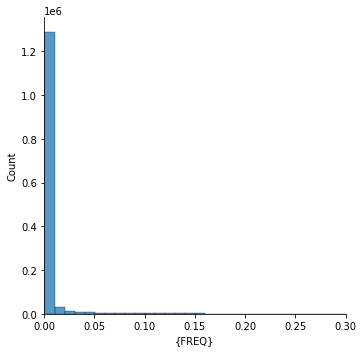

In [14]:
sns.displot(allele_frequency, x="{FREQ}", binwidth=0.01).set(xlim=(0, 0.3))

Above is a plot that shows a distribution of the allele frequency. We can now see that many of the alleles are rare and when we filter at the 0.01 cutoff there will be a large dropoff in the size of the dataset that we will run PCA on. 

Next, I will filter the dataset at a cutoff of 0.01 and write the results to a new output file to use in the further analysis.

In [16]:
%%bash
vcftools --gzvcf acs_mini_project.vcf.gz --remove-indels --maf 0.1 --recode --stdout | gzip -c > acs_mini_project_min_maf_001.vcf.gz


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf acs_mini_project.vcf.gz
	--maf 0.1
	--recode
	--remove-indels
	--stdout

Using zlib version: 1.2.11
After filtering, kept 1966 out of 1966 Individuals
Outputting VCF file...
After filtering, kept 49443 out of a possible 2203614 Sites
Run Time = 433.00 seconds


### Calculate proportion of missing data per individual

I will use vcftools to perform the missing individuals analysis

In [19]:
%%bash
vcftools --gzvcf acs_mini_project_min_maf_001.vcf.gz --missing-indv --out basic_vcf_statistics/missing_individual


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf acs_mini_project_min_maf_001.vcf.gz
	--missing-indv
	--out basic_vcf_statistics/missing_individual

Using zlib version: 1.2.11
After filtering, kept 1966 out of 1966 Individuals
Outputting Individual Missingness
After filtering, kept 49443 out of a possible 49443 Sites
Run Time = 9.00 seconds


In [22]:
missing_individual = pd.read_csv("basic_vcf_statistics/missing_individual.imiss", sep="\t")

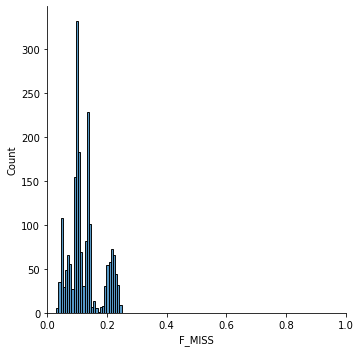

In [23]:
sns.displot(missing_individual, x="F_MISS").set(xlim=(0, 1))

We can see that the data is very complete. We should drop all individuals with less than 90% completeness. 

### Calculate proportion of missing data per site

In [20]:
missing_site = pd.read_csv("basic_vcf_statistics/missing_site.lmiss", sep="\t")

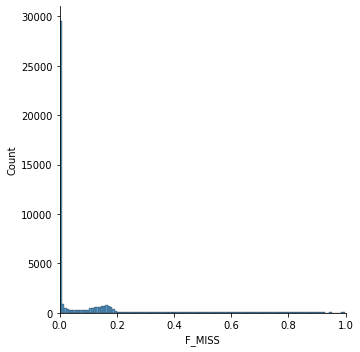

In [21]:
sns.displot(missing_site, x="F_MISS").set(xlim=(0, 1))

Just like before we can drop at 90% completeness

### Calculate heterozygosity and inbreeding coefficient per individual

In [24]:
%%bash
vcftools --gzvcf acs_mini_project_min_maf_001.vcf.gz --het --out  basic_vcf_statistics/heterozygote


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf acs_mini_project_min_maf_001.vcf.gz
	--het
	--out basic_vcf_statistics/heterozygote

Using zlib version: 1.2.11
After filtering, kept 1966 out of 1966 Individuals
Outputting Individual Heterozygosity
	Individual Heterozygosity: Only using biallelic SNPs.
	Individual Heterozygosity: Only using fully diploid SNPs.
After filtering, kept 49443 out of a possible 49443 Sites
Run Time = 10.00 seconds


In [25]:
heterozygote = pd.read_csv("basic_vcf_statistics/heterozygote.het", sep="\t")

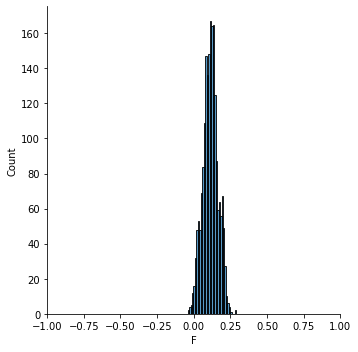

In [26]:
sns.displot(heterozygote, x="F").set(xlim=(-1, 1))

"Individuals that are e.g. inbred (strongly negative F), suffer from high sequencing error problems or contamination with DNA from another individual leading to inflated heterozygosity (high F), or PCR duplicates or low read depth leading to allelic dropout and thus underestimated heterozygosity (stongly negative F)". Our F score looks pretty normal.

Next, I will perform the final filtering of our dataset before running PCA.

In [28]:
%%bash
vcftools --gzvcf acs_mini_project_min_maf_001.vcf.gz --max-missing 0.9 --minQ 30 --recode --stdout | gzip -c > acs_mini_project_all_filtered.vcf.gz


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf acs_mini_project_min_maf_001.vcf.gz
	--minQ 30
	--max-missing 0.9
	--recode
	--stdout

Using zlib version: 1.2.11
After filtering, kept 1966 out of 1966 Individuals
Outputting VCF file...
After filtering, kept 33772 out of a possible 49443 Sites
Run Time = 68.00 seconds


## Principle Component Analysis (PCA)

In [40]:
import allel

In [41]:
callset = allel.read_vcf('acs_mini_project_all_filtered.vcf.gz')

Genotype Array

In [42]:
gt = allel.GenotypeArray(callset['calldata/GT'])
gt

<GenotypeArray shape=(33772, 1966, 2) dtype=int8>
1/1 0/1 0/0 0/1 0/1 ... 1/1 0/1 1/1 1/1 1/1
./. 1/1 1/1 1/1 ./. ... 1/1 0/1 1/1 1/1 1/1
0/0 0/0 1/1 0/1 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
./. ./. 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
./. ./. ./. 1/1 1/1 ... 1/1 1/1 1/1 1/1 1/1
./. ./. 1/1 0/0 0/0 ... 1/1 0/0 0/0 1/1 0/0

Allele Counts

In [43]:
ac = gt.count_alleles()[:]
ac

<AlleleCountsArray shape=(33772, 3) dtype=int32>
1468 2456    0
 397 3183    0
3482  448    0
...
3115  477    0
 459 3175    0
2883  775    0

Finding the number of multiallelic sites

In [44]:
np.count_nonzero(ac.max_allele() > 1)

114

Filtering to remove multiallelic sites and singletons 

In [45]:
np.count_nonzero((ac.max_allele() == 1) & ac.is_singleton(1))

0

Filtering to remove multiallelic sites and singletons 

In [46]:
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = gt.compress(flt, axis=0)
gf

<GenotypeArray shape=(33658, 1966, 2) dtype=int8>
1/1 0/1 0/0 0/1 0/1 ... 1/1 0/1 1/1 1/1 1/1
./. 1/1 1/1 1/1 ./. ... 1/1 0/1 1/1 1/1 1/1
0/0 0/0 1/1 0/1 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
./. ./. 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
./. ./. ./. 1/1 1/1 ... 1/1 1/1 1/1 1/1 1/1
./. ./. 1/1 0/0 0/0 ... 1/1 0/0 0/0 1/1 0/0

Transforming the genotype array to a 2d matrix to be analyzed using PCA

In [50]:
gn = gf.to_n_alt()
gn

array([[2, 1, 0, ..., 2, 2, 2],
       [0, 2, 2, ..., 2, 2, 2],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 2, ..., 0, 2, 0]], dtype=int8)

### Analyzing LD

In [48]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

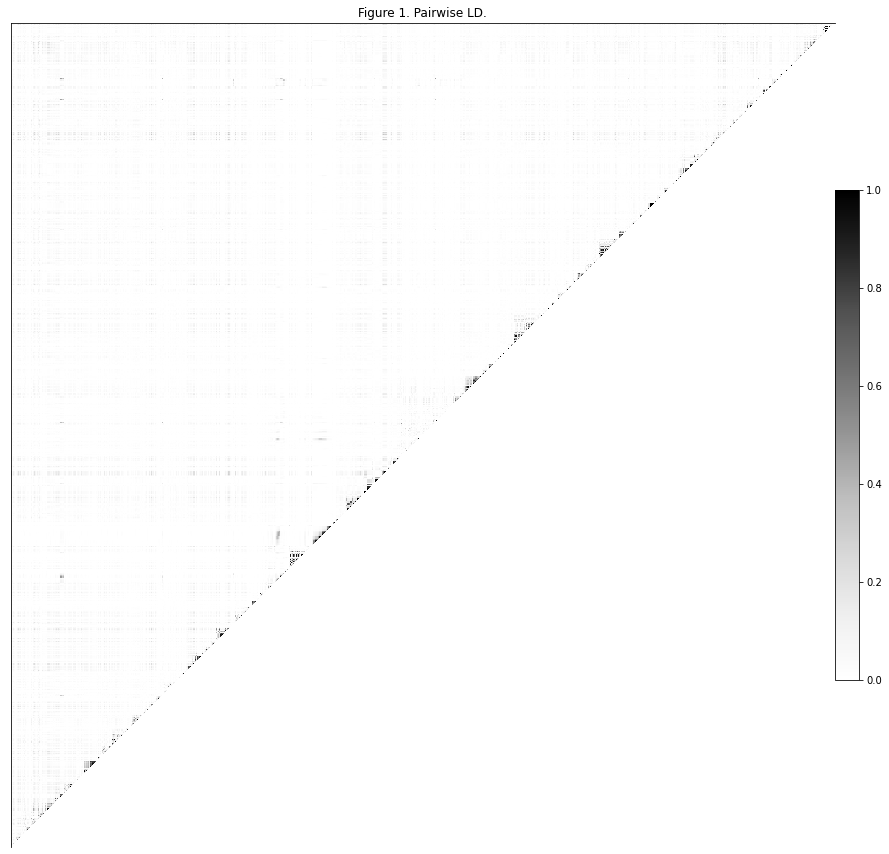

In [51]:
plot_ld(gn[:1000], 'Figure 1. Pairwise LD.')

The black spots above indicate SNPs

In [52]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [53]:
gnu = ld_prune(gn, size=500, step=200, threshold=.1, n_iter=5)

iteration 1 retaining 12871 removing 20787 variants
iteration 2 retaining 12605 removing 266 variants
iteration 3 retaining 12579 removing 26 variants
iteration 4 retaining 12573 removing 6 variants
iteration 5 retaining 12572 removing 1 variants


In [54]:
np.savetxt("pruned_matrix.csv", gnu, delimiter=',')

Pairwise LD after LD Pruning

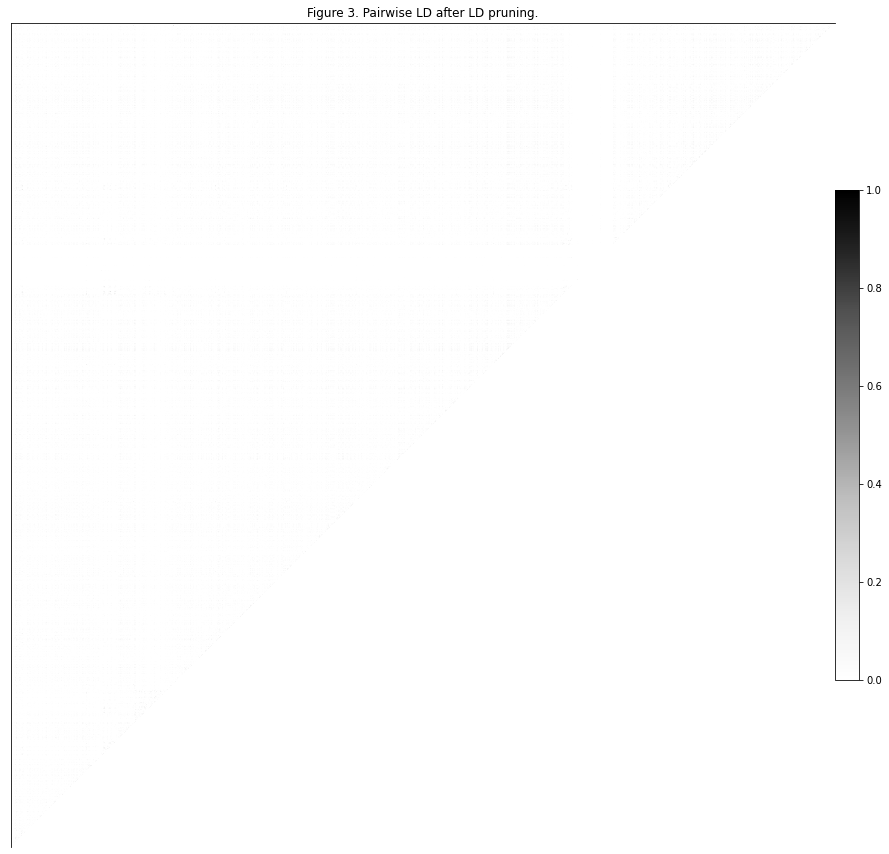

In [55]:
plot_ld(gnu[:1000], 'Figure 3. Pairwise LD after LD pruning.')

After pruning we can see that only non linked SNPs are retained.

In [56]:
gnu = gnu[:]
gnu

array([[2, 1, 0, ..., 2, 2, 2],
       [0, 1, 0, ..., 2, 1, 1],
       [1, 2, 0, ..., 1, 0, 1],
       ...,
       [1, 1, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

Buidling Principal Components

In [58]:
coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson')

Saving principal componentds to CSV

Loading metadata

In [59]:
df_samples = pd.read_csv('acs_mini_project_labels.txt', delimiter='\t')
df_samples.head()

,sample_id,ancestry
0,TGG_1,NaN
1,TGG_2,NaN
2,TGG_3,eas
3,TGG_4,NaN
4,TGG_5,eas


Replacing NaN with "unknown"

In [60]:
df_samples = df_samples.fillna('unknown')

In [61]:
ancestry = df_samples.ancestry.unique()
ancestry

array(['unknown', 'eas', 'nfe', 'fin', 'amr', 'sas', 'afr'], dtype=object)

Checking to make sure the replacement has been done

In [62]:
df_samples.head()

,sample_id,ancestry
0,TGG_1,unknown
1,TGG_2,unknown
2,TGG_3,eas
3,TGG_4,unknown
4,TGG_5,eas


Setting color scheme

In [63]:
pop_colors = {
    'unknown': '#FF0000',
    'eas': '#008000',
    'nfe': '#00FFFF',
    'fin': '#90EE90',
    'amr': '#FFA500',
    'sas': '#8B0000',
    'afr': '#1E90FF'
}

Function that will generate the PCA plots

In [64]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in ancestry:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colors[pop], 
                label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_population=None):
    if sample_population is None:
        sample_population = df_samples.ancestry.values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

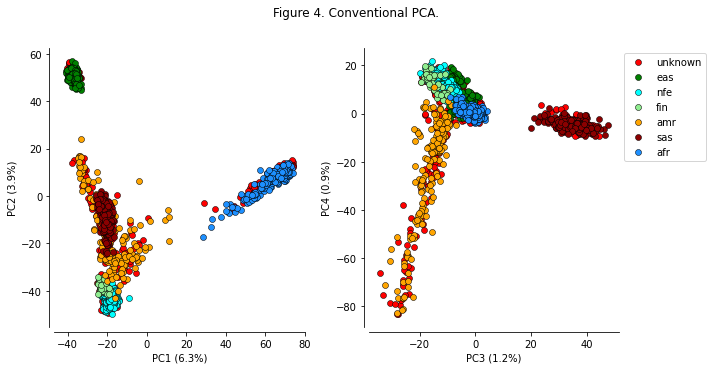

In [67]:
fig = fig_pca(coords1, model1, 'Figure 4. Conventional PCA.')
plt.savefig('Conventional_PCA.png',  dpi=199, bbox_inches='tight')
plt.savefig('Conventional_PCA.jpg',  dpi=199, bbox_inches='tight')

Looks like populations separated pretty neatly, eas and afr have clear distinctions, while populations from nfe, fin, amr, and sas form more of a continuum. Still you can see that they are localized so it should be possible to tell them apart. It is interesting if amr is american, as in US, since you have a lot of mixed ancestries there it makes sense that they form the loosest cluster.


## Training and testing a Random Forest classifier

Displaying ancestry counts

In [68]:
df_samples.groupby('ancestry').ancestry.count()

ancestry
afr        382
amr        155
eas        253
fin         58
nfe        210
sas        228
unknown    680
Name: ancestry, dtype: int64

In [69]:
df_samples

,sample_id,ancestry
0,TGG_1,unknown
1,TGG_2,unknown
2,TGG_3,eas
3,TGG_4,unknown
4,TGG_5,eas
...,...,...
1961,TGG_1962,unknown
1962,TGG_1963,unknown
1963,TGG_1964,sas
1964,TGG_1965,unknown


Create data frame

In [70]:
PC_pandas = pd.DataFrame(data=coords1)
PC_pandas

,0,1,2,3,4,5,6,7,8,9
0,-15.646064,-39.475914,-9.541553,1.952420,-8.764842,6.980779,-4.486231,5.610099,-7.001755,5.389335
1,-13.172674,-33.691212,-9.595048,-0.655413,-8.668006,4.479679,-7.550264,4.417383,-2.742804,0.612179
2,-36.585007,49.844078,-3.308040,5.463295,-15.295311,7.011049,-11.172266,4.989995,5.065707,-6.531219
3,-36.198181,48.068169,-5.473024,6.304071,-14.154540,7.090737,-5.807991,9.479265,9.761770,-6.155133
4,-35.555450,52.257923,-4.640702,2.203565,-14.975621,8.573726,0.166897,4.131045,1.641056,-0.331038
...,...,...,...,...,...,...,...,...,...,...
1961,-19.716736,-12.104259,36.318802,-0.181389,8.798810,-10.778437,2.065461,6.733742,4.748222,0.619849
1962,-23.540440,-13.166361,28.907967,1.985068,24.182522,-0.554705,0.597072,-7.436142,-6.323284,1.817612
1963,-20.386478,-10.868484,31.864052,0.273915,28.348648,0.974590,-2.030662,-8.520596,-5.601083,2.324620
1964,-22.311750,-10.150811,32.266876,2.691685,26.641642,-0.957284,4.064870,-6.491142,-3.077523,0.585402


In [71]:
df_samples["sample_id"]

0          TGG_1
1          TGG_2
2          TGG_3
3          TGG_4
4          TGG_5
          ...   
1961    TGG_1962
1962    TGG_1963
1963    TGG_1964
1964    TGG_1965
1965    TGG_1966
Name: sample_id, Length: 1966, dtype: object

Combining the two data frames

In [72]:
combined_dataframe = pd.concat([df_samples["ancestry"].reset_index(drop=True), PC_pandas], axis=1)
combined_dataframe.index = df_samples["sample_id"]
combined_dataframe

,ancestry,0,1,2,3,4,5,6,7,8,9
sample_id,,,,,,,,,,,
TGG_1,unknown,-15.646064,-39.475914,-9.541553,1.952420,-8.764842,6.980779,-4.486231,5.610099,-7.001755,5.389335
TGG_2,unknown,-13.172674,-33.691212,-9.595048,-0.655413,-8.668006,4.479679,-7.550264,4.417383,-2.742804,0.612179
TGG_3,eas,-36.585007,49.844078,-3.308040,5.463295,-15.295311,7.011049,-11.172266,4.989995,5.065707,-6.531219
TGG_4,unknown,-36.198181,48.068169,-5.473024,6.304071,-14.154540,7.090737,-5.807991,9.479265,9.761770,-6.155133
TGG_5,eas,-35.555450,52.257923,-4.640702,2.203565,-14.975621,8.573726,0.166897,4.131045,1.641056,-0.331038
...,...,...,...,...,...,...,...,...,...,...,...
TGG_1962,unknown,-19.716736,-12.104259,36.318802,-0.181389,8.798810,-10.778437,2.065461,6.733742,4.748222,0.619849
TGG_1963,unknown,-23.540440,-13.166361,28.907967,1.985068,24.182522,-0.554705,0.597072,-7.436142,-6.323284,1.817612
TGG_1964,sas,-20.386478,-10.868484,31.864052,0.273915,28.348648,0.974590,-2.030662,-8.520596,-5.601083,2.324620


In [73]:
unknown_ancestry = combined_dataframe[combined_dataframe.ancestry == "unknown"]
known_ancestry = combined_dataframe[combined_dataframe.ancestry != "unknown"]

In [74]:
known_ancestry

,ancestry,0,1,2,3,4,5,6,7,8,9
sample_id,,,,,,,,,,,
TGG_3,eas,-36.585007,49.844078,-3.308040,5.463295,-15.295311,7.011049,-11.172266,4.989995,5.065707,-6.531219
TGG_5,eas,-35.555450,52.257923,-4.640702,2.203565,-14.975621,8.573726,0.166897,4.131045,1.641056,-0.331038
TGG_7,nfe,-20.402922,-49.011078,-8.134690,11.786460,-11.402131,-6.968986,-3.629624,-9.580206,4.103026,-0.227765
TGG_8,nfe,-19.573910,-43.648239,-11.922574,9.358809,-12.816887,-8.234091,1.124991,-10.959659,2.413799,-1.175975
TGG_9,nfe,-20.323128,-46.356987,-11.737400,8.702449,-6.851580,11.229801,3.566983,5.188107,0.141699,-12.223917
...,...,...,...,...,...,...,...,...,...,...,...
TGG_1952,sas,-21.529936,-13.973286,32.297108,-4.114039,-1.558470,-7.383879,-2.968389,-10.859649,-0.413673,-2.130690
TGG_1954,sas,-21.420584,-12.066594,34.663548,-7.207254,0.613334,13.408989,-4.717616,-3.552092,-3.632144,4.092447
TGG_1956,sas,-18.587275,-12.917371,38.951832,-4.402032,2.676167,12.410004,-4.047101,-4.204770,-3.455391,1.500775


Since the machine learning algorithms cannot process categorical data we will convert it to numerical

In [75]:
factor = pd.factorize(known_ancestry['ancestry'])
factor

(array([0, 0, 1, ..., 4, 4, 4]),
 Index(['eas', 'nfe', 'fin', 'amr', 'sas', 'afr'], dtype='object'))

In [76]:
known_ancestry.ancestry = factor[0]
definitions = factor[1]

/usr/local/Cellar/jupyterlab/2.2.9_1/libexec/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [77]:
print(definitions)

Index(['eas', 'nfe', 'fin', 'amr', 'sas', 'afr'], dtype='object')


Splitting the data into dependant (which we will use to predict) and independant (which we will predict)

In [78]:
dependant_vars = known_ancestry.iloc[:, 1:]
independant_vars = known_ancestry.iloc[:, 0]

In [79]:
dependant_vars

,0,1,2,3,4,5,6,7,8,9
sample_id,,,,,,,,,,
TGG_3,-36.585007,49.844078,-3.308040,5.463295,-15.295311,7.011049,-11.172266,4.989995,5.065707,-6.531219
TGG_5,-35.555450,52.257923,-4.640702,2.203565,-14.975621,8.573726,0.166897,4.131045,1.641056,-0.331038
TGG_7,-20.402922,-49.011078,-8.134690,11.786460,-11.402131,-6.968986,-3.629624,-9.580206,4.103026,-0.227765
TGG_8,-19.573910,-43.648239,-11.922574,9.358809,-12.816887,-8.234091,1.124991,-10.959659,2.413799,-1.175975
TGG_9,-20.323128,-46.356987,-11.737400,8.702449,-6.851580,11.229801,3.566983,5.188107,0.141699,-12.223917
...,...,...,...,...,...,...,...,...,...,...
TGG_1952,-21.529936,-13.973286,32.297108,-4.114039,-1.558470,-7.383879,-2.968389,-10.859649,-0.413673,-2.130690
TGG_1954,-21.420584,-12.066594,34.663548,-7.207254,0.613334,13.408989,-4.717616,-3.552092,-3.632144,4.092447
TGG_1956,-18.587275,-12.917371,38.951832,-4.402032,2.676167,12.410004,-4.047101,-4.204770,-3.455391,1.500775


Our dependant variables are our principle components, the independent are ancestries.

In [80]:
independant_vars

sample_id
TGG_3       0
TGG_5       0
TGG_7       1
TGG_8       1
TGG_9       1
           ..
TGG_1952    4
TGG_1954    4
TGG_1956    4
TGG_1960    4
TGG_1964    4
Name: ancestry, Length: 1286, dtype: int64

When training machine learning models, we always need to split our dataset into the train and test subset. The training subset will train the model. The test subset we use to estimate how accurate is our model before we proceed to inputing data for which we do not know the correct output, in our case this the subset with unknown ancestries.

In [98]:
dependant_vars_train, dependant_vars_test, independant_vars_train, independant_vars_test = train_test_split(dependant_vars, independant_vars, test_size = 0.20, random_state = 42)

Training our classifier:
n_estimators: This is the number of trees in the random forest classification. We have defined 10 trees in our random forest.

criterion: This is the loss function used to measure the quality of the split. There are two available options in sklearn — gini and entropy. We have used entropy.

random_state: This is the seed used by the random state generator for randomizing the dataset.

In [99]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(dependant_vars_train, independant_vars_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

Here it will predict the ancestries in the test dataset

In [100]:
independant_vars_predicted = classifier.predict(dependant_vars_test)

In [101]:
reversefactor = dict(zip(range(6),definitions))
independant_vars_test = np.vectorize(reversefactor.get)(independant_vars_test)
independant_vars_predicted = np.vectorize(reversefactor.get)(independant_vars_predicted)

Here is a visualization of the results of the test

In [102]:
print(pd.crosstab(independant_vars_test, independant_vars_predicted, rownames=['Actual ancestry'], colnames=['Predicted ancestry']))

Predicted ancestry  afr  amr  eas  fin  nfe  sas
Actual ancestry                                 
afr                  71    0    0    0    0    0
amr                   0   41    0    0    1    0
eas                   0    0   48    0    0    0
fin                   0    0    0   10    0    0
nfe                   0    0    0    0   43    0
sas                   0    0    0    0    0   44


We can see that it is nearly perfect with just one being incorrectly predicted. In the matrix we compare the actual independent values (ancestries) of our test dataset with predicted ones from our classifier.

Now I will prepare the unknown data for analysis using the classification model

In [103]:
PC_unknown_ancestry = unknown_ancestry.iloc[:,1:]
PC_unknown_ancestry

In [105]:
unknown_ancestry_predicted = classifier.predict(PC_unknown_ancestry)

In [106]:
unknown_ancestry_predicted = np.vectorize(reversefactor.get)(unknown_ancestry_predicted)

Now I am changing back from numerical values for ancestry to categorical (text), so that I can interpret the results

In [107]:
PC_unknown_ancestry_array = np.array(PC_unknown_ancestry)

Changing the results back to an array

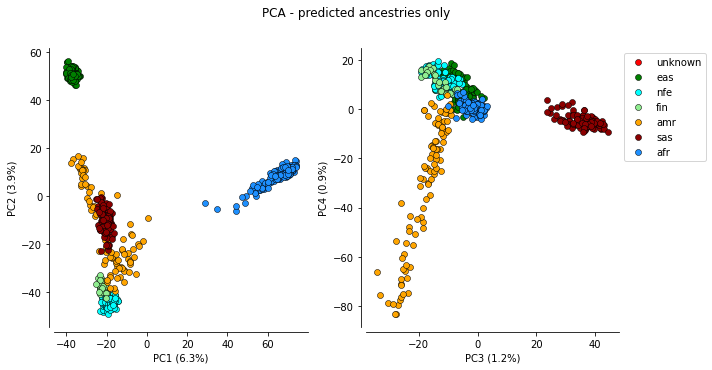

In [108]:
fig = fig_pca(PC_unknown_ancestry_array, model1, 'PCA - predicted ancestries only', unknown_ancestry_predicted)
plt.savefig('PCA_predicted_ancestries.png',  dpi=199, bbox_inches='tight')
plt.savefig('PCA_predicted_ancestries.jpg',  dpi=199, bbox_inches='tight')

Looking at the results above we can see that there are now no longer any unkonwn ancestries because we have predicted all of them. Additionally, all of the ancestries appear to be correctly predicted because there are no visual discrepancies in the PCA clustering. 